In [19]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

SIGNAL_COUNT = 7
CLASS_COUNT = 4
NUM_FOLFDS = 10

clean_dataset = np.loadtxt("wifi_db/clean_dataset.txt", delimiter="\t")
noisy_dataset = np.loadtxt("wifi_db/noisy_dataset.txt", delimiter=" ")

TEST_DATASET = clean_dataset

In [20]:
# decision_tree_learning

def all_same_label(dataset) -> bool:
    # check if all samples have the same label
    return np.all(dataset[:, SIGNAL_COUNT] == dataset[0, SIGNAL_COUNT])


def entropy(dataset) -> float:
    # H(D) = - Sum(P(X) * log2(P(X))) for each X in Classes
    
    # Return 0.0 if the dataset is empty
    if len(dataset) == 0:
        return 0.0

    # Count occurrences of each class in the specified column
    labels = dataset[:, SIGNAL_COUNT].astype(int) - 1
    counts = np.bincount(labels, minlength=CLASS_COUNT)

    # Calculate probabilities by dividing counts by total number of samples
    probabilities = counts / len(dataset)
    probabilities = probabilities[probabilities > 0]  # Remove zero probabilities

    # Calculate entropy using vectorized numpy operations
    return -np.sum(probabilities * np.log2(probabilities))

def calculate_IG(full_dataset, l_dataset, r_dataset) -> float:
    # Calculate the information gain
    # IG(D1, D2) = H(D) - H(D1, D2)
    # H(D1, D2) = (|D1|/|D|)H(D1) + (|D2|/|D|)H(D2)

    # H(D) and |D| - calculating entropy for the entire dataset
    full_entropy = entropy(full_dataset)

    full_length = len(full_dataset)

    # (|D1|/|D|) and (|D2|/|D|) - calculate the proportions of l_dataset and r_dataset relative to full dataset
    if full_length > 0:
        l_fraction = len(l_dataset) / full_length
        r_fraction = len(r_dataset) / full_length
    else:
        l_fraction = 0.0
        r_fraction = 0.0

    # H(D1) and H(D2) - calculate the entropy of the left and right datasets
    l_entropy = entropy(l_dataset)
    r_entropy = entropy(r_dataset)

    # H(D1, D2)- calculate the combined entropy of the split using the proportions as weighting
    combined_entropy = l_fraction * l_entropy + r_fraction * r_entropy

    # return IG(D1, D2)
    return full_entropy - combined_entropy

def pick_split_value(dataset, attribute: int) -> Tuple[float, float]:
    # find the best value to split by
    highest_IG = 0.0
    best_value = None

    # Sort the dataset based on the specified attribute
    dataset = dataset[dataset[:, attribute].argsort()]

    # Initialize the previous value to the first entry in the sorted dataset.
    prev_value = dataset[0][attribute]

    for i in range(1, len(dataset) - 1):
        # Skip duplicate values to avoid redundant splits.
        if dataset[i][attribute] == prev_value:
            continue
        else: 
            prev_value = dataset[i][attribute]

        # Split the dataset into left and right subsets at the current index and calculate IG for this split
        l_dataset = dataset[:i]
        r_dataset = dataset[i:]

        information_gain = calculate_IG(dataset, l_dataset, r_dataset)

        # If the current Information Gain is the highest encountered so far, update the vals to return 
        if information_gain > highest_IG:
            highest_IG = information_gain
            best_value = dataset[i][attribute]
    
    return (highest_IG, best_value)

def find_split(dataset):
    # find the best split
    
    # if the dataset contains only 2 records, find the first differing attribute.
    if len(dataset) == 2:
        i = 0
        while dataset[0][i] == dataset[1][i]:
            i = i + 1
        # print("Splitting attribute " + str(i) + " at value " + str(max(dataset[0][i], dataset[1][i])))
        # Return the index of the first differing attribute and the max value in that attribute
        return (i, max(dataset[0][i], dataset[1][i]))
    
    best_attribute = 0
    best_value = None
    best_IG = 0.0

    # Iterate over all attributes to find the split with the best Information Gain
    for i in range(SIGNAL_COUNT):
        (information_gain, value) = pick_split_value(dataset, i)

        if value is not None and information_gain > best_IG:
            best_IG = information_gain
            best_attribute = i
            best_value = value

    # If no split value was found, set it to the value at the best attribute
    if best_value is None:
        best_value = dataset[1][best_attribute]
    
    # print("Splitting attribute " + str(best_attribute) + " at value " + str(best_value))
    return (best_attribute, best_value)

def decision_tree_learning(dataset, depth) -> Tuple[dict, int]:
    # Recursively build a decision tree based on the dataset and current depth.
    # print("Depth: " + str(depth))
    if depth > 50:
        return ({"error": "error"}, depth)

    # Base case: if all instances in the dataset have the same label, return that label as a leaf node.
    if all_same_label(dataset):
        # print("Value: " + str(dataset[0][SIGNAL_COUNT]))
        return ({"value": dataset[0][SIGNAL_COUNT]}, depth)
    else:
        # Find the best attribute and value to split the dataset on.
        (split_attribute, split_value) = find_split(dataset)

        # Partition the dataset into left and right subsets based on the split value.
        l_dataset = dataset[dataset[:,split_attribute] < split_value]
        r_dataset = dataset[dataset[:,split_attribute] >= split_value]

        # Store the split attribute and value.
        node = {"split_attribute": split_attribute, "split_value": split_value}

        # Recrusively build the left and right branches
        l_branch, l_depth = decision_tree_learning(l_dataset, depth+1)
        r_branch, r_depth = decision_tree_learning(r_dataset, depth+1)

        # Attach the branches to the current node
        node["l_branch"] = l_branch
        node["r_branch"] = r_branch

        return (node, max(l_depth, r_depth))

In [21]:
tree = decision_tree_learning(TEST_DATASET, 0)[0]

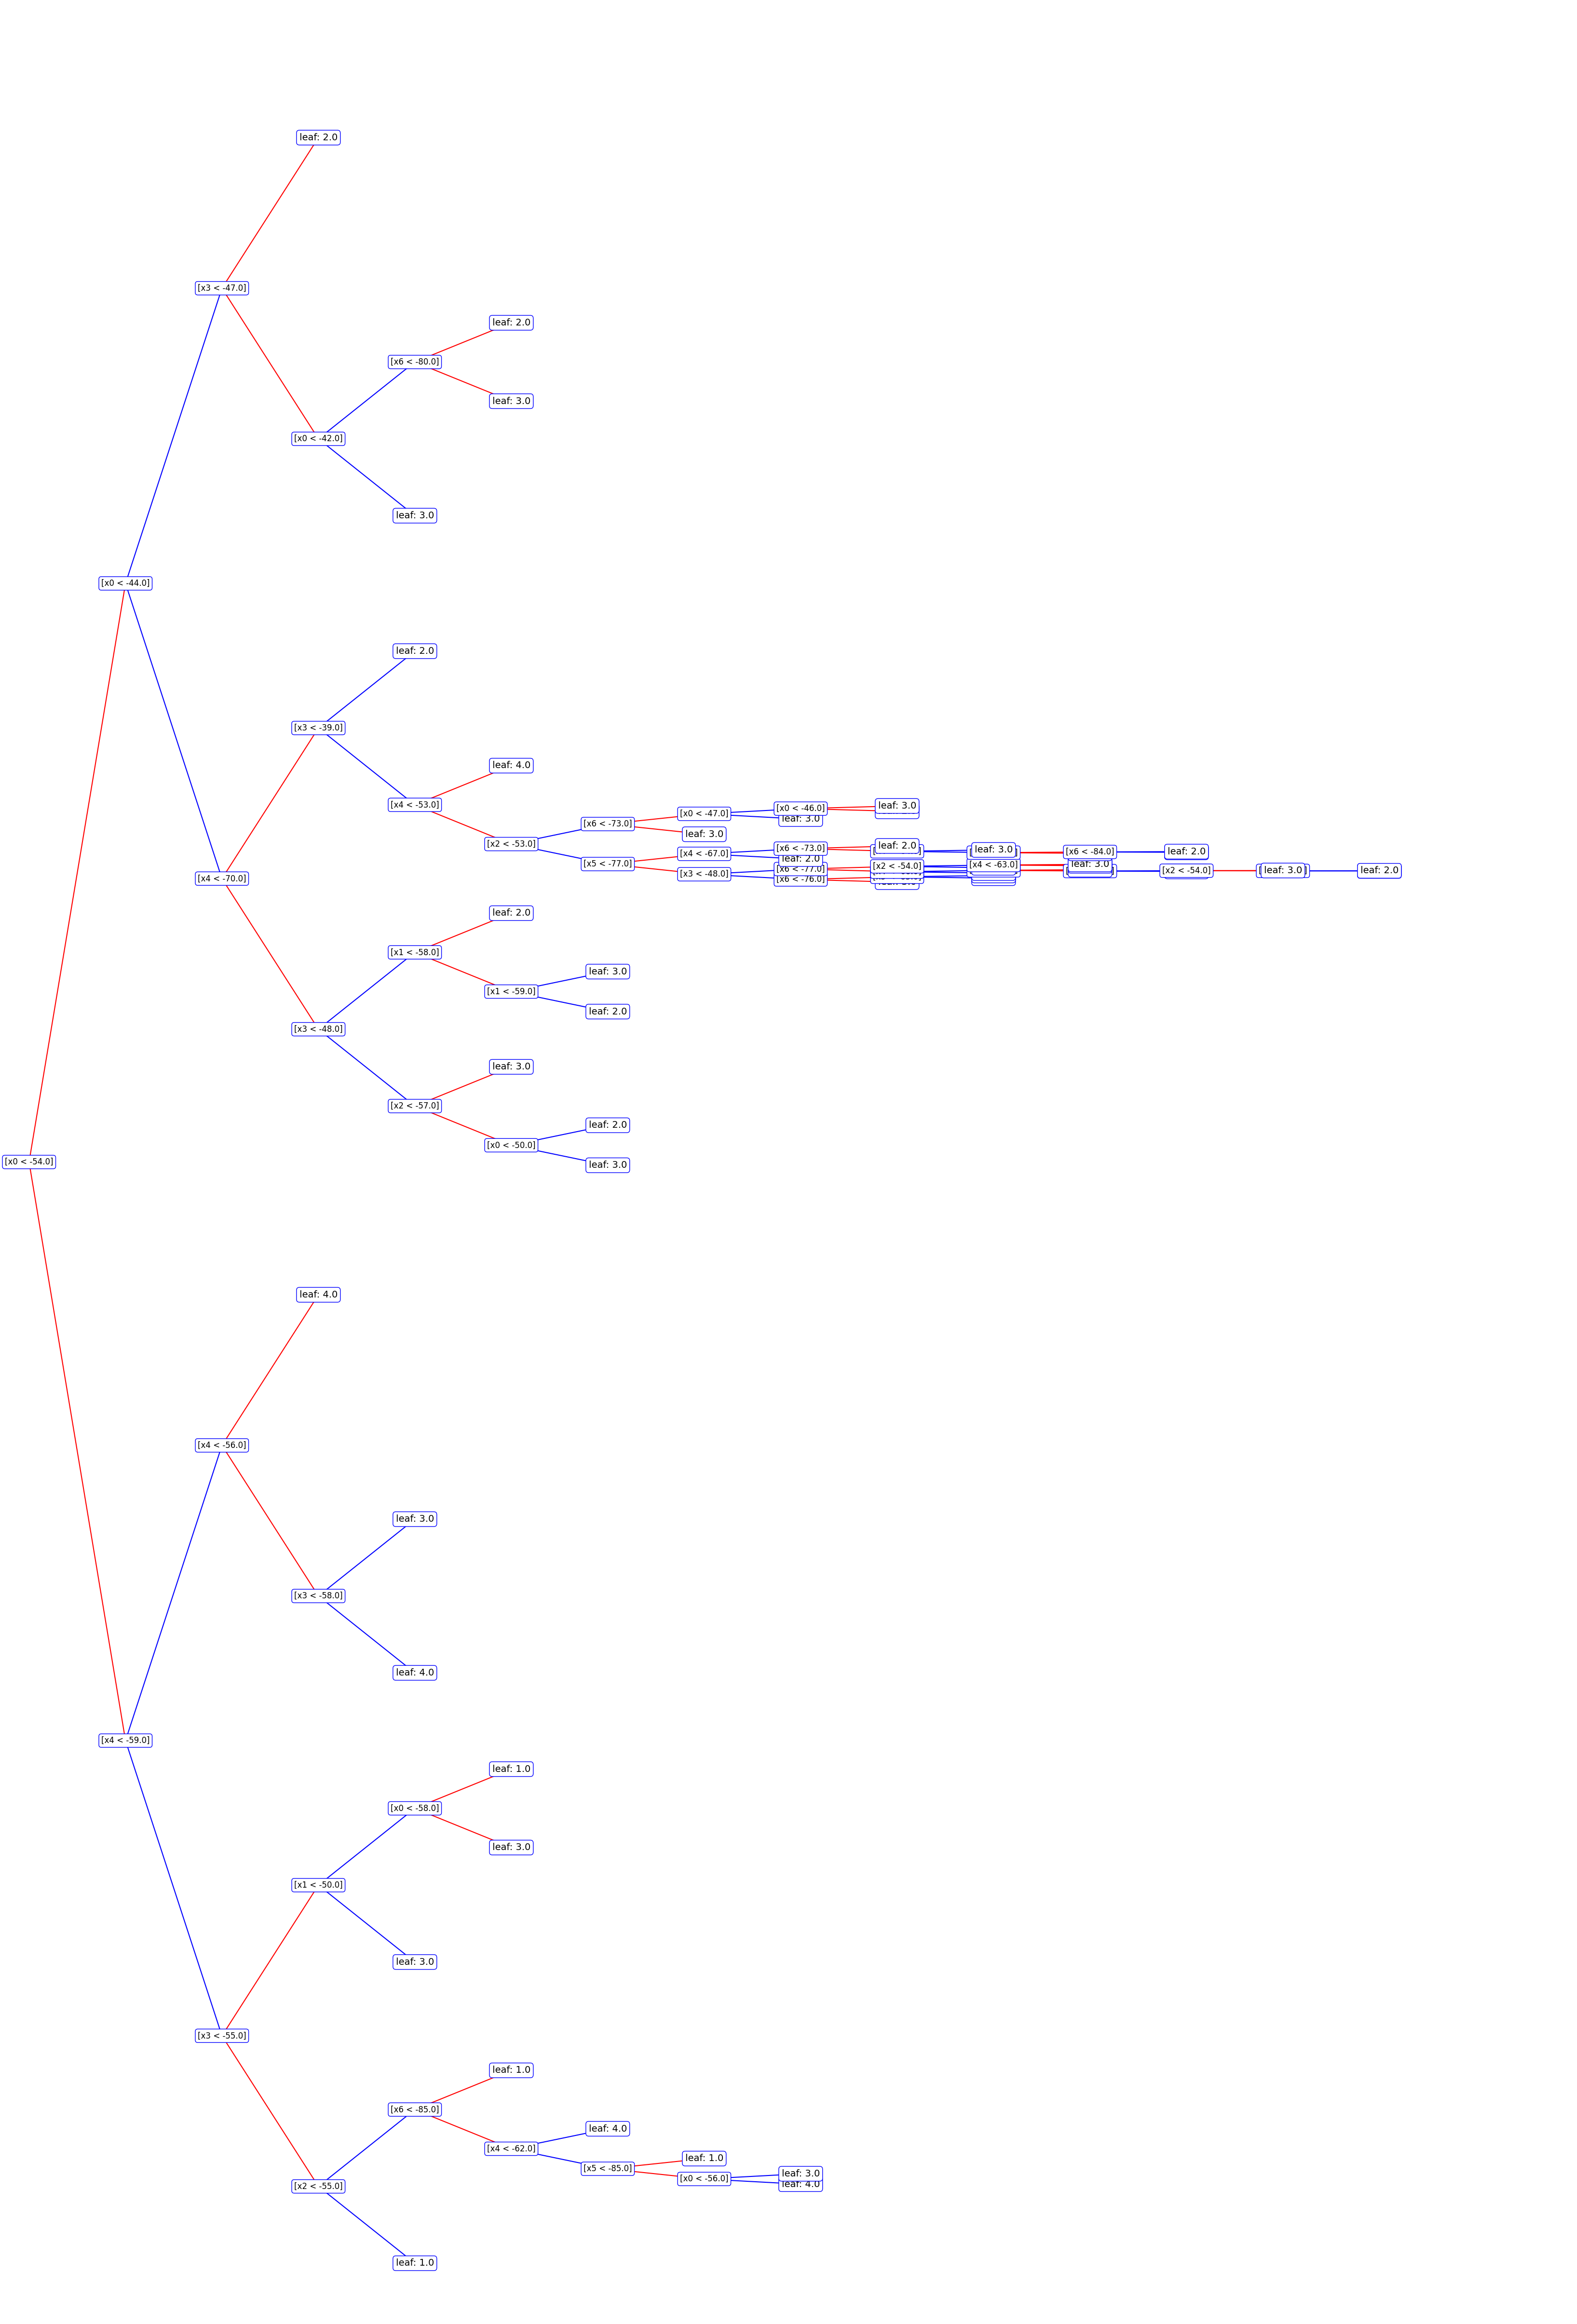

In [64]:
# tree visualiser

# adjust size here later to make it fit depending on the tree depth
fig_height = 48
fig_width = 32
fig, ax = plt.subplots(figsize=(fig_width, fig_height)) 
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.axis("off")
# Child offset factor to reduce overlap
child_offset_factor = 1.4
# Horizontal distance between nodes
x_change_between_nodes = 2
# fontsize of labels
label_fontsize = 14

def plot_node(node, x, y, child_offset, line_color, depth=0):
    # Alternate line colors for branches
    if line_color == "blue":
        line_color = "red"
    else:
        line_color = "blue"
    
    # Check if the current node is a leaf node
    if "value" in node:
        # Annotate the leaf node with its value
        ax.annotate(f"leaf: {node['value']}", (x, y), fontsize=label_fontsize, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
    else:
        # Annotate the decision node with the split attribute and value
        ax.annotate(f"[x{node['split_attribute']} < {node['split_value']}]", (x, y), fontsize=12, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue"))
        
        # Adjust child_offset based on depth to reduce overlap
        new_child_offset = child_offset / (child_offset_factor ** depth)
        
        # Recursively plot the left and right branches       
        plot_node(node["l_branch"], x+x_change_between_nodes, y-new_child_offset, child_offset/child_offset_factor, line_color, depth+1)
        plot_node(node["r_branch"], x+x_change_between_nodes, y+new_child_offset, child_offset/child_offset_factor, line_color, depth+1)

        # Draw lines connecting the node to its children
        ax.add_line(plt.Line2D((x, x+x_change_between_nodes), (y, y-new_child_offset), c=line_color))
        ax.add_line(plt.Line2D((x, x+x_change_between_nodes), (y, y+new_child_offset), c=line_color))

plot_node(tree, 0, fig_height//2, fig_height//4, "blue")
# Adjust layout to reduce margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.savefig("tree.png", bbox_inches='tight')

In [23]:
# Metrics

def confusion(y_actual, y_prediction, class_labels):
    # Initialize a confusion matrix with zeros
    confusion = np.zeros((len(class_labels), len(class_labels)), dtype=np.int64)

    # Populate the confusion matrix
    for i, label in enumerate(class_labels):
        # Find indices where the actual labels match the current class label
        indices = y_actual == label
        predictions = y_prediction[indices]  # Get predictions for those indices

        # Count unique predictions for the current class
        (unique_labels, counts) = np.unique(predictions, return_counts=True)
        frequency_dict = dict(zip(unique_labels, counts))  # Create a frequency dictionary

        # Fill the confusion matrix for the current class
        for j, class_label in enumerate(class_labels):
            confusion[i, j] = frequency_dict.get(class_label, 0)

    return confusion 

def accuracy(confusion):
    # Calculate accuracy as the sum of true positives divided by total instances
    if np.sum(confusion) > 0:
        return np.sum(np.diag(confusion)) / np.sum(confusion)
    return 0.0  

def precision(confusion):
    # Initialize precision array
    precision = np.zeros((len(confusion),))
    for c in range(confusion.shape[0]):
        # Calculate precision for each class
        if np.sum(confusion[:, c]) > 0:  # Check if there are any positive predictions
            precision[c] = confusion[c, c] / np.sum(confusion[:, c])  # True positives / predicted positives

    return precision 
def recall(confusion):
    # Initialize recall array
    recall = np.zeros((len(confusion),))
    for col in range(confusion.shape[0]):
        # Calculate recall for each class
        if np.sum(confusion[col, :]) > 0:  # Check if there are any actual positives
            recall[col] = confusion[col, col] / np.sum(confusion[col, :])  # True positives / actual positives

    return recall 

def f1_score(precision, recall):
    f1 = np.zeros((len(precision),))
    for c, (p, r) in enumerate(zip(precision, recall)):
        # Calculate F1 score for each class
        if p + r > 0:  # Avoid division by zero
            f1[c] = 2 * p * r / (p + r) 

    return f1


In [24]:
# Evaluation

def is_leaf(tree):
    # Check if the given node is a leaf node
    return not "l_branch" in tree

def get_label(tree, values):
    # Recursively retrieve the label
    if is_leaf(tree):
        # If the node is a leaf, return its value (label)
        return tree["value"]
    
    # Determine which branch to traverse based on the split attribute and value
    traverse_direction = (
        "l_branch" if values[tree["split_attribute"]] < tree["split_value"] else "r_branch"
    )
    
    return get_label(tree[traverse_direction], values)

def evaluate(test_db, tree):
    # Evaluate the performance of the decision tree on the test dataset
    y_actual = np.array(test_db[:, -1])  # Extract the actual labels from the test dataset
    
    if len(y_actual) == 0:
        return 0.0 
    
    # Generate predictions by traversing the decision tree for each row in the test dataset
    y_prediction = np.array([get_label(tree, row) for row in test_db])
    
    # Calculate the accuracy of the predictions
    return np.sum(y_actual == y_prediction) / len(y_actual)


In [25]:
# Cross Validation
def cross_validate(data, n_folds = NUM_FOLFDS):
    # shuffle the dataset randomly
    np.random.seed(42)
    np.random.shuffle(data)

    
    fold_size = len(data) // n_folds     # Calculate the size of each fold
    confusions = []
    accuracies = []
    recalls = []
    f1_scores = []
    precisions = []

    for i in range(n_folds):
        # print(f"Fold {i + 1}/{n_folds}")
        # Define the test set for the current fold and the training set (by concatenating the remaining data)
        test_db = data[i * fold_size : (i + 1) * fold_size]
        train_db = np.concatenate([data[:i * fold_size], data[(i + 1) * fold_size:]])

        # Train the decision tree using the training set
        tree = decision_tree_learning(train_db, 0)[0]
        
        # Get actual labels from the test set and predict labels using the trained tree for the test set
        y_actual = np.array(test_db[:, -1])
        y_prediction = np.array([get_label(tree, row) for row in test_db])
        class_labels = np.unique(y_actual)

        # Calculate confusion matrix, accuracy, precision, recall, and F1 score
        confusions.append(confusion(y_actual, y_prediction, class_labels))
        accuracies.append(accuracy(confusions[-1]))
        recalls.append(recall(confusions[-1]))
        f1_scores.append(f1_score(precision(confusions[-1]), recalls[-1]))
        precisions.append(precision(confusions[-1]))

    return (np.mean(confusions, axis=0),
            np.mean(accuracies), 
            np.mean(precisions), 
            np.mean(recalls), 
            np.mean(f1_scores))

In [26]:
# Printing the metrics

confusion_mean, accuracy_mean, precision_mean, recall_mean, f1_score_mean = cross_validate(TEST_DATASET)
print(f'Mean Accuracy: {round(accuracy_mean, 10)}')
print(f'Mean Precision: {round(precision_mean, 10)}')
print(f'Mean Recall: {round(recall_mean, 10)}')
print(f'Mean F1 Score: {round(f1_score_mean, 10)}')
print(f'Confusion Matrix:\n{confusion_mean}')

Mean Accuracy: 0.973
Mean Precision: 0.9737217024
Mean Recall: 0.9726801823
Mean F1 Score: 0.9728641995
Confusion Matrix:
[[49.3  0.   0.2  0.5]
 [ 0.  48.3  1.7  0. ]
 [ 0.2  2.  47.6  0.2]
 [ 0.5  0.   0.1 49.4]]
